In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import os
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
import ast
from community import community_louvain
import collections
from collections import Counter
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
df = pd.read_csv('../data/clean/combined.csv')

In [4]:
del df['Unnamed: 0']
del df['Unnamed: 0.1']

In [5]:
df.dtypes

authors    object
paper      object
dtype: object

In [6]:
df['authors'] = df['authors'].apply(ast.literal_eval)

In [7]:
type(df['authors'][1]) # sanity check

list

In [8]:
df.head()

,authors,paper
0,"[Qiming Chen, Umeshwar Dayal]",Multi-Agent Cooperative Transactions for E-Com...
1,"[Emmanuel Cecchet, Renaud Lachaize, Takoua Abd...",Evaluation of a Group Communication Middleware...
2,"[Robert Grob, Stefanie Kethers, Stephan Jacobs]",Towards CIS in Quality Management - Integratio...
3,"[Evaggelia Pitoura, George Samaras, Panos K. C...",An Evaluation of the Java-Based Approaches to ...
4,"[Arne Koschel, Günter von Bültzingsloewen, Ral...",Poster on Accept Heterogeneity: An Event Monit...


In [9]:
df = df[~df['authors'].apply(lambda x: any(not author.strip() for author in x))]

In [10]:
G = nx.Graph()

In [11]:
for index, row in df.iterrows():
    authors = row['authors']
    for pair in combinations(authors, 2):
        if G.has_edge(*pair):
            G[pair[0]][pair[1]]['weight'] += 1
        else:
            G.add_edge(*pair, weight=1)

In [12]:
G.remove_edges_from(nx.selfloop_edges(G))
core = nx.k_core(G, 100)

In [13]:
max_edge = max(core.edges(data=True), key=lambda x: x[2]['weight']) # find authors with the most collaborations
node1, node2, data = max_edge

print(f"Node 1: {node1}")
print(f"Node 2: {node2}")

max_edge

Node 1: Shiguang Shan
Node 2: Xilin Chen 0001


('Shiguang Shan', 'Xilin Chen 0001', {'weight': 218})

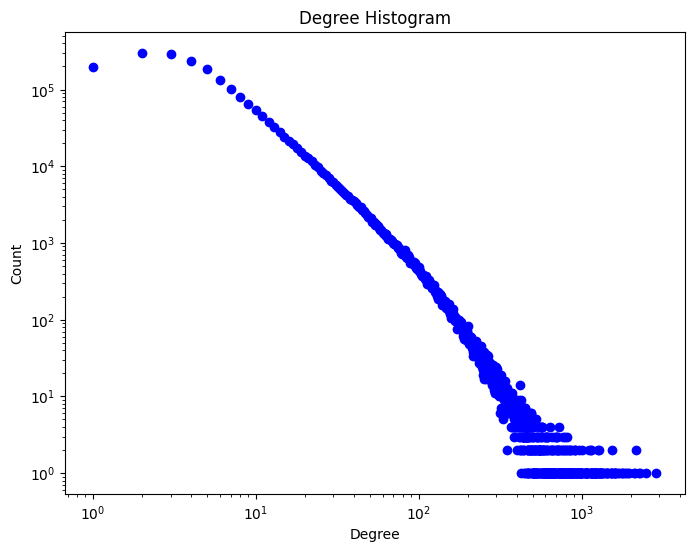

In [14]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

plt.figure(figsize=(8,6))
plt.scatter(deg, cnt, color='b')
plt.xscale('log')
plt.yscale('log')
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()


In [15]:
# compute the best partition
partition = community_louvain.best_partition(core)
# count the number of nodes in each community
community_counts = Counter(partition.values())

# print the number of nodes in each community
for community, count in community_counts.items():
    print(f"Community {community}: {count} nodes")

Community 1: 236 nodes
Community 2: 325 nodes
Community 3: 186 nodes
Community 4: 115 nodes
Community 5: 204 nodes
Community 0: 102 nodes


In [16]:
total_collaborations = sum(weight for _, _, weight in G.edges(data='weight')) # average number of aollaborations for the entire network
average_collaborations = total_collaborations / G.number_of_nodes()
print("Average number of collaborations per author:", average_collaborations)


Average number of collaborations per author: 8.897549793511903


In [17]:
density = nx.density(core) # find network density, eliciting how interconnected all the authors are
print("Density of the graph:", density)


Density of the graph: 0.1397932293317369


In [18]:
largest_clique = nx.make_max_clique_graph(core)
print("The largest clique size:", len(largest_clique.nodes()))
print("Authors in the largest clique:", largest_clique.nodes())

The largest clique size: 4721
Authors in the largest clique: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209

In [19]:
density = nx.density(largest_clique) # find density of largest clique
print("Density of the largest clique:", density)

Density of the largest clique: 0.8585687282570843


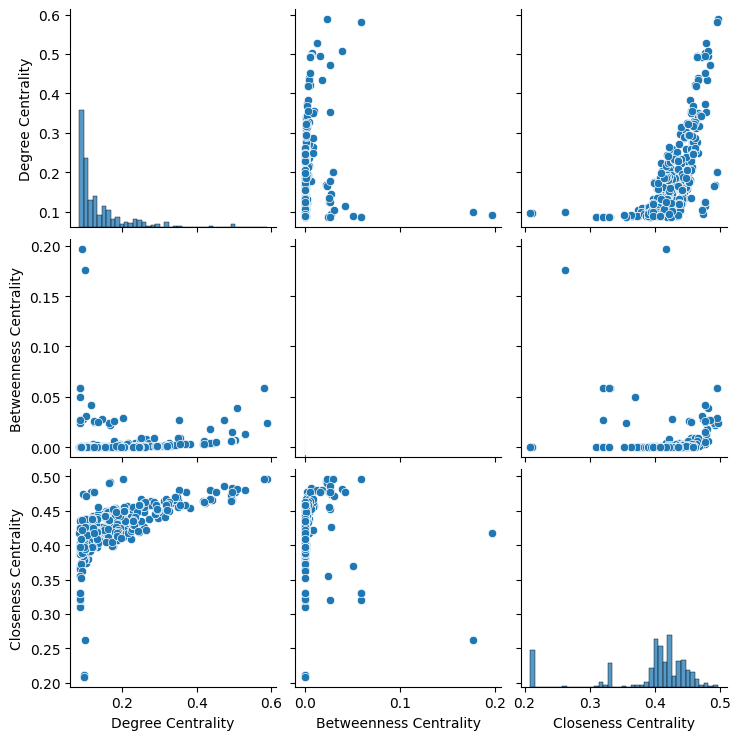

In [20]:
def plot_centrality_correlation(G,path=""):
    if nx.is_directed(G):
         in_degree_centrality = nx.in_degree_centrality(G)
         out_degree_centrality = nx.out_degree_centrality(G)
         in_closeness_centrality = nx.closeness_centrality(G, distance = 'weight', wf_improved=False)
         out_closeness_centrality = nx.closeness_centrality(G.reverse(), distance = 'weight', wf_improved=False)
         betweenness_centrality = nx.betweenness_centrality(G.to_undirected())


         df = pd.DataFrame({
            'In Degree Centrality': list(in_degree_centrality.values()),
            'Out Degree Centrality': list(out_degree_centrality.values()),
            'In Closeness Centrality': list(in_closeness_centrality.values()),
            'Out Closeness Centrality': list(out_closeness_centrality.values()),
            'Betweenness Centrality': list(betweenness_centrality.values())
        })
    else:
         degree_centrality = nx.degree_centrality(G)
         betweenness_centrality = nx.betweenness_centrality(G)
         closeness_centrality = nx.closeness_centrality(G, distance = 'weight')

         df = pd.DataFrame({
            'Degree Centrality': list(degree_centrality.values()),
            'Betweenness Centrality': list(betweenness_centrality.values()),
            'Closeness Centrality': list(closeness_centrality.values())
        })

    pair_plot = sns.pairplot(df)

    plt.show()

plot_centrality_correlation(core)

In [21]:
def network_summary(G):

    def centrality_stats(x):
        x1=dict(x)
        x2=np.array(list(x1.values())); #print(x2)
        print("	min:" ,min(x2))
        print("	mean:" ,np.mean(x2))
        print("	median:" ,np.median(x2))
        # print("	mode:" ,stats.mode(x2)[0][0])
        print("	max:" ,max(x2))
        x=dict(x)
        sort_dict=dict(sorted(x1.items(), key=lambda item: item[1],reverse=True))
        print("	top nodes:",list(sort_dict)[0:6])
        print("	          ",list(sort_dict.values())[0:6])

    try:
        print("GENERAL")
        print("	number of nodes:",len(list(G.nodes)))
        print("	number of edges:",len(list(G.edges)))

        print("	is_directed:", nx.is_directed(G))
        print("	is_weighted:" ,nx.is_weighted(G))


        if(nx.is_directed(G)):
            print("IN-DEGREE (NORMALIZED)")
            centrality_stats(nx.in_degree_centrality(G))
            print("OUT-DEGREE (NORMALIZED)")
            centrality_stats(nx.out_degree_centrality(G))
        else:
            print("	number_connected_components", nx.number_connected_components(G))
            print("	number of triangle: ",len(nx.triangles(G).keys()))
            print("	density:" ,nx.density(G))
            print("	average_clustering coefficient: ", nx.average_clustering(G))
            print("	degree_assortativity_coefficient: ", nx.degree_assortativity_coefficient(G))
            print("	is_tree:" ,nx.is_tree(G))

            if(nx.is_connected(G)):
                print("	diameter:" ,nx.diameter(G))
                print("	radius:" ,nx.radius(G))
                print("	average_shortest_path_length: ", nx.average_shortest_path_length(G))

            #CENTRALITY
            print("DEGREE (NORMALIZED)")
            centrality_stats(nx.degree_centrality(G))

            print("CLOSENESS CENTRALITY")
            centrality_stats(nx.closeness_centrality(G))

            print("BETWEEN CENTRALITY")
            centrality_stats(nx.betweenness_centrality(G))
    except:
        print("unable to run")

network_summary(core)

GENERAL
	number of nodes: 1168
	number of edges: 95273
	is_directed: False
	is_weighted: True
	number_connected_components 1
	number of triangle:  1168
	density: 0.1397932293317369
	average_clustering coefficient:  0.8763951603833143
	degree_assortativity_coefficient:  0.1379226901834502
	is_tree: False
	diameter: 6
	radius: 3
	average_shortest_path_length:  2.5811749480578934
DEGREE (NORMALIZED)
	min: 0.08568980291345331
	mean: 0.1397932293317369
	median: 0.10882604970008569
	max: 0.5878320479862896
	top nodes: ['Huchuan Lu', 'Fahad Shahbaz Khan', 'Martin Danelljan', 'Radu Timofte', 'Ales Leonardis', 'Dong Wang 0004']
	           [0.5878320479862896, 0.5801199657240789, 0.5287060839760069, 0.5072836332476436, 0.5029991431019709, 0.4961439588688946]
CLOSENESS CENTRALITY
	min: 0.2165522360363704
	mean: 0.40711765471293515
	median: 0.4270032930845225
	max: 0.5583732057416267
	top nodes: ['Huchuan Lu', 'Fahad Shahbaz Khan', 'Martin Danelljan', 'Radu Timofte', 'Ales Leonardis', 'Matej Kris

In [22]:
num_papers_by_karpathy = df['authors'].apply(lambda authors: 'Yann LeCun' in authors).sum()
print("Number of papers by Yann LeCun:", num_papers_by_karpathy)

titles_by_karpathy = df[df['authors'].apply(lambda authors: 'Yann LeCun' in authors)]['paper'].tolist()
print("Titles of articles by Andrej Karpathy:", titles_by_karpathy)

Number of papers by Yann LeCun: 170
Titles of articles by Andrej Karpathy: ['Hardware requirements for neural-net optical character recognition.', 'Traffic sign recognition with multi-scale Convolutional Networks.', 'MDETR - Modulated Detection for End-to-End Multi-Modal Understanding.', 'What is the best multi-stage architecture for object recognition?', 'Unsupervised Learning of Spatiotemporally Coherent Metrics.', 'Ask the locals: Multi-way local pooling for image recognition.', 'Predicting Deeper into the Future of Semantic Segmentation.', 'CNP: An FPGA-based processor for Convolutional Networks.', 'Pushing Stochastic Gradient towards Second-Order Methods - Backpropagation Learning with Transformations in Nonlinearities.', 'Handwritten Digit Recognition: Applications of Neural Net Chips and Automatic Learning.', 'EBLearn: Open-Source Energy-Based Learning in C++.', 'MoDeep: A Deep Learning Framework Using Motion Features for Human Pose Estimation.', 'Dynamic Factor Graphs for Time 

In [23]:
# find authors with highest degree centrality
degree_centrality = nx.degree_centrality(G)

# Get the 5 authors with the highest degree centrality
top_authors = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
top_authors = [author[0] for author in top_authors]

In [24]:
print(top_authors)

['Yang Liu', 'Wei Wang', 'Wei Zhang', 'Yu Zhang', 'Wei Liu']


In [25]:
# Extract all papers of each of the top 5 authors
author_papers = {author: df[df['authors'].apply(lambda x: author in x)]['paper'].tolist() for author in top_authors}

In [26]:
nlp = spacy.load('en_core_web_sm')

# for each author, apply NER to the titles of their papers and get the most common entities
author_entities = {}
for author, papers in author_papers.items():
    entities = []
    for paper in papers:
        doc = nlp(paper)
        entities.extend([ent.text for ent in doc.ents])
    author_entities[author] = Counter(entities).most_common()


In [27]:
# concatenate all papers of each author into a single string
author_papers_text = {author: ' '.join(papers) for author, papers in author_papers.items()}

# convert the text into vectors
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(author_papers_text.values())

# calculate cosine similarity
cosine_sim = cosine_similarity(X)
print(cosine_sim)

[[1.         0.970065   0.96708242 0.96388891 0.96343802]
 [0.970065   1.         0.96703587 0.96489403 0.96407049]
 [0.96708242 0.96703587 1.         0.95905528 0.96207979]
 [0.96388891 0.96489403 0.95905528 1.         0.95643988]
 [0.96343802 0.96407049 0.96207979 0.95643988 1.        ]]


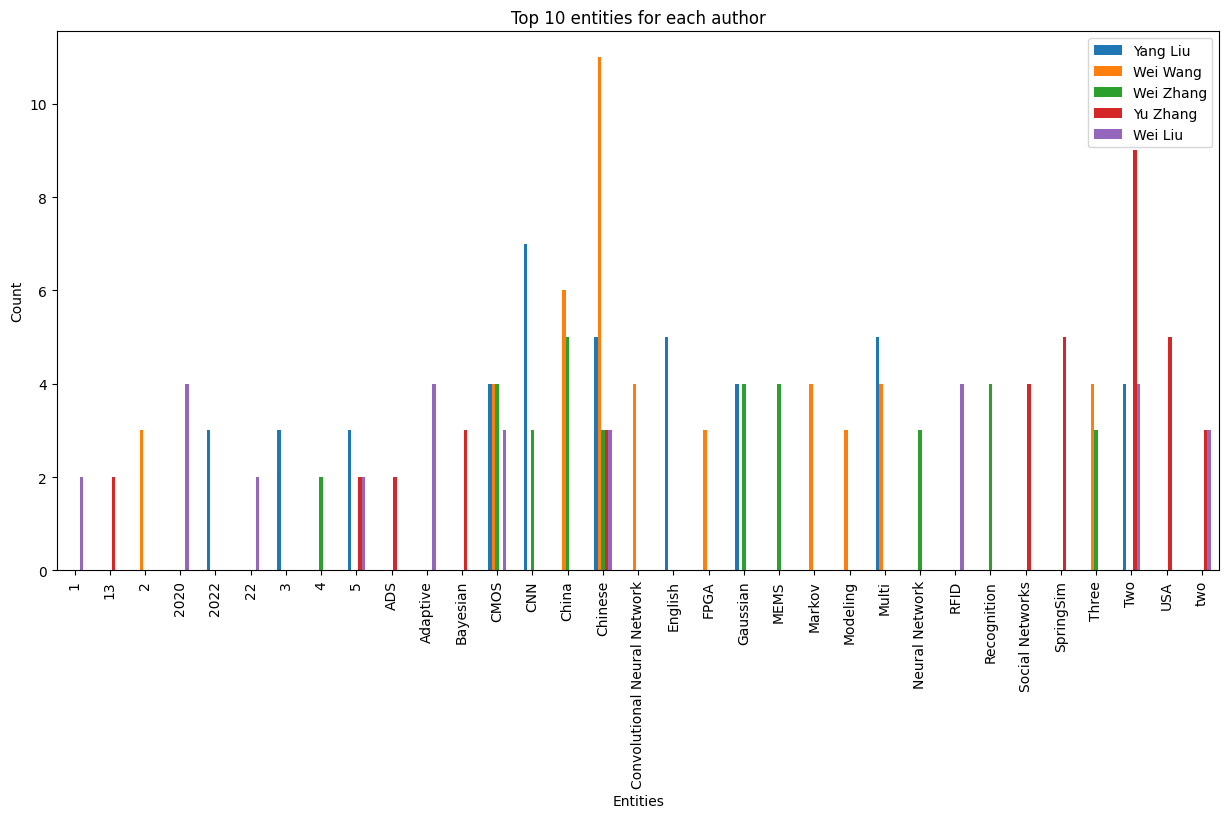

In [28]:
# Initialize an empty DataFrame
df_entities = pd.DataFrame()

# For each author, create a DataFrame and concatenate
for author, entities in author_entities.items():
    df_author = pd.DataFrame(entities, columns=['Entity', 'Count']).set_index('Entity')
    df_author.columns = [author]
    df_entities = pd.concat([df_entities, df_author], axis=1, sort=True)

# Fill NA values with 0
df_entities.fillna(0, inplace=True)

# Select top 10 entities for each author
df_top_entities = df_entities.apply(lambda x: x.nlargest(10))

# Plot
df_top_entities.plot(kind='bar', figsize=(15, 7))
plt.title('Top 10 entities for each author')
plt.ylabel('Count')
plt.xlabel('Entities')
plt.show()


In [29]:
# Get the 5 authors with the highest degree centrality
worst_authors = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=False)[:5]
worst_authors = [author[0] for author in worst_authors]

In [30]:
worst_authors

['Enrico Giacoletto',
 'Nathalie Habing',
 'Sridhar Gantimahapatruni',
 'C. Wittemann',
 'H. Kunst']

In [31]:
# Extract all papers of each of the top 5 authors
worst_author_papers = {author: df[df['authors'].apply(lambda x: author in x)]['paper'].tolist() for author in worst_authors}

nlp = spacy.load('en_core_web_sm')

# for each author, apply NER to the titles of their papers and get the most common entities
worst_author_entities = {}
for author, papers in worst_author_papers.items():
    worst_entities = []
    for paper in papers:
        doc = nlp(paper)
        worst_entities.extend([ent.text for ent in doc.ents])
    worst_author_entities[author] = Counter(entities).most_common()

# concatenate all papers of each author into a single string
worst_author_papers_text = {author: ' '.join(papers) for author, papers in worst_author_papers.items()}

# convert the text into vectors
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(worst_author_papers_text.values())

# calculate cosine similarity
worst_cosine_sim = cosine_similarity(X)
print(worst_cosine_sim)


[[1.         0.06744604 0.         0.         0.        ]
 [0.06744604 1.         0.         0.         0.        ]
 [0.         0.         1.         0.10109763 0.10109763]
 [0.         0.         0.10109763 1.         1.        ]
 [0.         0.         0.10109763 1.         1.        ]]


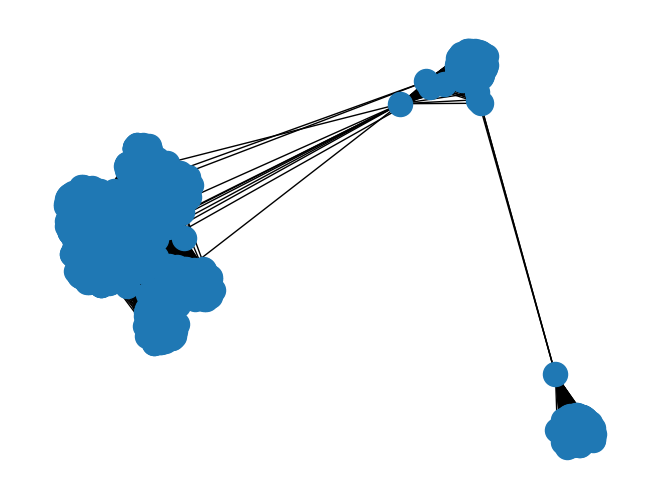

In [32]:
nx.draw(core)